In [4]:
# import the libraries/framework
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests
#import geocoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

# 1. Analyze & Transform the Kaggle data set for NY properties sale and identify the Borough with most sales 
### Read NY property sale data file from Kaggle. 
#### This data file  **nyc-rolling-sales.csv** has been downloaded and stored locally for convienience

In [6]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING-CLASS-AT-PRESENT,ADDRESS,APARTMENT-NUMBER,ZIP-CODE,RESIDENTIAL-UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALEPRICE,SALEDATE
0,4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
1,5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00
2,6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,12/9/2016 0:00
3,7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,9/23/2016 0:00
4,8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,11/17/2016 0:00


## Find the Borough with most sales among the different city boroughs

In [8]:
# find the top/maximum # of sales in NY city Boroughs
df_ny_sale_data_grouped=df_ny_sale_data[['BOROUGH','NEIGHBORHOOD']].groupby('BOROUGH').count()
df_ny_sale_data_grouped=df_ny_sale_data_grouped.sort_values(by=['BOROUGH'], ascending=True)
#df_ny_sale_data_grouped.reset_index(inplace=True)
df_ny_sale_data_grouped

,NEIGHBORHOOD
BOROUGH,
Bronx,26736
Brooklyn,7049
Manhattan,18306
Queens,24047
Staten Island,8410


## Plot the sale data for all Boroughs

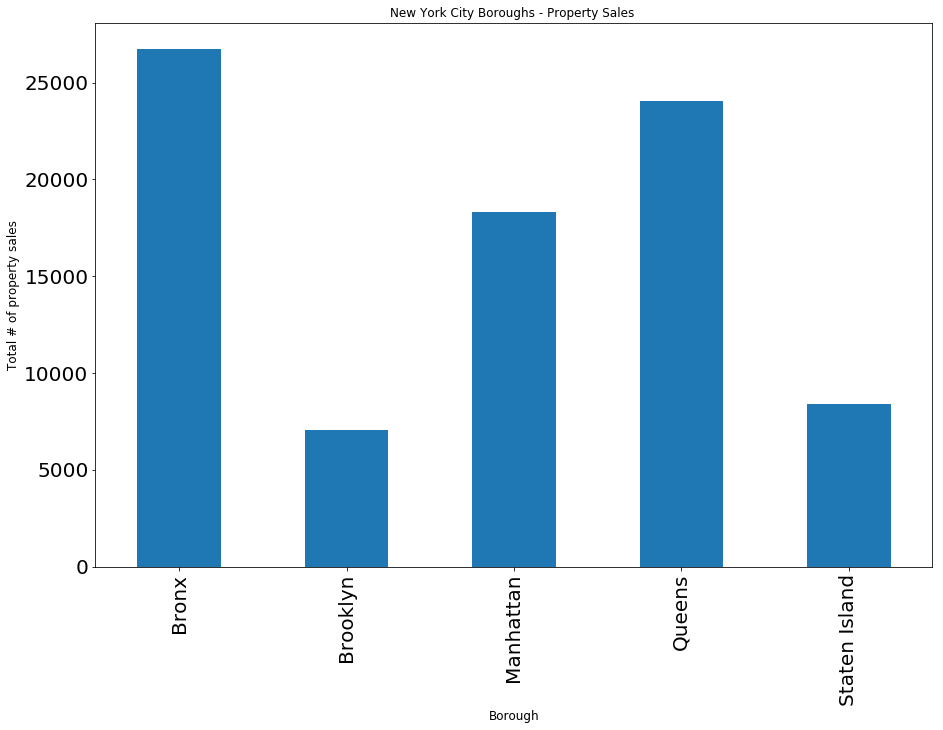

In [9]:
ax = df_ny_sale_data_grouped.plot(kind='bar', title ="New York City Boroughs - Property Sales ", figsize=(15, 10), legend=False, fontsize=20)
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Total # of property sales", fontsize=12)
plt.show()

## Find the top Borough with most sales

In [10]:
# Find the top Borough with most sales
top_borough = df_ny_sale_data_grouped.iloc[0].name
print("Top Borough with most property sales : ",top_borough)

Top Borough with most property sales :  Bronx


# 2. Download & Explore NY data set
Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For convenience, downloaded the file locally, so we can simply run a `wget` command and access the data. 

In [11]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data
The data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [12]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
#newyork_data
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe and examine the result
##### We will be focusing our analysis on the borough with most sales i.e Bronx

In [13]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
# loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                    'Neighborhood': neighborhood_name,
                    'Latitude': neighborhood_lat,
                    'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

# only Bronx neighborhoods
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of Bronx (top borough in terms of most sales) in New York City.

In [14]:
address = 'Bronx, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bronx are 40.8466508, -73.8785937.


#### Create a map of Bronx, NY with neighborhoods superimposed on top.

In [15]:
# create map of Bronx using latitude and longitude values
map_bronx = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(bronx_data['Latitude'], bronx_data['Longitude'], bronx_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bronx)  
    
map_bronx

# 3. Leverage  Foursquare APIs to explore the top Borough(most sales) and its neighborhoods

### Using the APIs explore Bronx neighborhoods and get the top recommended venues.
#### Then use the venue list to segment/cluster locations and visualize them in a map.

##### Define Foursquare Credentials and Version

In [35]:
# The code was removed by Watson Studio for sharing.

Your credentails:


#### Let's explore the first neighborhood in our dataframe.
Get the neighborhood's latitude and longitude values.

In [17]:
bronx_data.loc[0, 'Neighborhood']

'Wakefield'

In [18]:
neighborhood_latitude = bronx_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = bronx_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = bronx_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


#### Now, let's explore the Borough/Neighborhoods and get the top 100 venues within a radius of 1000 meters.
First, let's create the GET request URL. 

In [36]:
# The code was removed by Watson Studio for sharing.

#### Function to get the venues for all the neighborhoods in Bronx

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Invoke the above function on each neighborhood and create a new dataframe called *bronx_top_venues*.

Send the GET request and examine the resutls

In [21]:
# invoke the function
bronx_top_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                           latitudes=bronx_data['Latitude'],
                           longitudes=bronx_data['Longitude']
                           )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


#### Let's check the size of the resulting dataframe

In [22]:
print(bronx_top_venues.shape)
bronx_top_venues.head(10)

(1705, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Seton Falls Park,40.888414,-73.840186,Park
2,Wakefield,40.894705,-73.847201,Wreckhouse,40.898510,-73.855356,Music Venue
3,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Foodtown,40.896419,-73.855642,Supermarket
5,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
6,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
7,Wakefield,40.894705,-73.847201,Fine Fare,40.889245,-73.843579,Supermarket
8,Wakefield,40.894705,-73.847201,E&L Bakery,40.893564,-73.856997,Bakery
9,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint


In [23]:
bronx_top_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,38,38,38,38,38,38
Baychester,32,32,32,32,32,32
Bedford Park,50,50,50,50,50,50
Belmont,72,72,72,72,72,72
Bronxdale,73,73,73,73,73,73
Castle Hill,23,23,23,23,23,23
City Island,36,36,36,36,36,36
Claremont Village,4,4,4,4,4,4
Clason Point,6,6,6,6,6,6


##  Analyze Each Neighborhood

In [24]:
# one hot encoding
bronx_onehot = pd.get_dummies(bronx_top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_onehot['Neighborhood'] = bronx_top_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

bronx_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Board Shop,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Buffet,Burger Joint,Business Service,Café,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Kitchen Supply Store,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Recording Studio,Rental Service,Restaurant,River,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Track,Trail,Tram Station,Vietnamese Restaurant,Volleyball Court,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
bronx_onehot.shape

(1705, 166)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [26]:
bronx_grouped = bronx_onehot.groupby('Neighborhood').mean().reset_index()
bronx_grouped

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Board Shop,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Buffet,Burger Joint,Business Service,Café,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Exhibit,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kids Store,Kitchen Supply Store,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Recording Studio,Rental Service,Restaurant,River,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Track,Trail,Tram Station,Vietnamese Restaurant,Volleyball Court,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,Allerton,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.131579,0.026316,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.078947,0.026316,0.026316,0.026316,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.00,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.00000,0.026316,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.026316,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Baychester,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.00000

In [27]:
bronx_grouped.shape

(52, 166)

#### Let's print each neighborhood along with the top 5 most common venues

In [28]:
num_top_venues =5

for hood in bronx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bronx_grouped[bronx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0  Chinese Restaurant  0.13
1         Pizza Place  0.11
2         Supermarket  0.08
3       Deli / Bodega  0.08
4          Laundromat  0.05


----Baychester----
                venue  freq
0       Shopping Mall  0.09
1  Spanish Restaurant  0.06
2      Clothing Store  0.06
3   Electronics Store  0.06
4  Chinese Restaurant  0.06


----Bedford Park----
            venue  freq
0     Pizza Place  0.12
1            Park  0.10
2           Diner  0.08
3  Baseball Field  0.06
4  Farmers Market  0.04


----Belmont----
                venue  freq
0  Italian Restaurant  0.18
1         Pizza Place  0.10
2       Deli / Bodega  0.07
3                Café  0.06
4              Bakery  0.06


----Bronxdale----
                venue  freq
0         Pizza Place  0.16
1       Deli / Bodega  0.10
2  Italian Restaurant  0.07
3  Chinese Restaurant  0.05
4              Bakery  0.05


----Castle Hill----
                venue  freq
0       Deli / Bodega  0.13
1      

#### Convert into a *pandas* dataframe
Function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 5 venues for each neighborhood.

In [30]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bronx_grouped['Neighborhood']

for ind in np.arange(bronx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_grouped.iloc[ind, :], num_top_venues)

## List of neighborhoods with most common/top pick venues

In [31]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Chinese Restaurant,Pizza Place,Supermarket,Deli / Bodega,American Restaurant
1,Baychester,Shopping Mall,Chinese Restaurant,Clothing Store,Pizza Place,Spanish Restaurant
2,Bedford Park,Pizza Place,Park,Diner,Baseball Field,Botanical Garden
3,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Café
4,Bronxdale,Pizza Place,Deli / Bodega,Italian Restaurant,Bakery,Chinese Restaurant
5,Castle Hill,Deli / Bodega,Baseball Field,Pizza Place,Wine Shop,Rental Service
6,City Island,Seafood Restaurant,Italian Restaurant,Harbor / Marina,American Restaurant,Park
7,Claremont Village,Grocery Store,Deli / Bodega,Park,Zoo Exhibit,Farmers Market
8,Clason Point,Pool,Lounge,River,Scenic Lookout,Gym / Fitness Center
9,Co-op City,Pizza Place,Shopping Mall,Liquor Store,Baseball Field,Dumpling Restaurant


# 4. Cluster Neighborhoods
*k*-means to cluster the neighborhood into 5 clusters

In [32]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

bronx_grouped_clustering = bronx_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bronx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 4, 0, 1, 1, 2, 3, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bronx_merged = bronx_data

# merge bronx_grouped with bronx_data to add latitude/longitude for each neighborhood
bronx_merged = bronx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bronx_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Caribbean Restaurant,Supermarket,Pizza Place,Burger Joint,Check Cashing Service
1,Bronx,Co-op City,40.874294,-73.829939,0,Pizza Place,Shopping Mall,Liquor Store,Baseball Field,Dumpling Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Diner,Deli / Bodega,Shopping Mall,Asian Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,1,Pizza Place,Bar,Plaza,Park,Mexican Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,1,Park,Pizza Place,Diner,Plaza,Deli / Bodega


###  let's visualize the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_merged['Latitude'], bronx_merged['Longitude'], bronx_merged['Neighborhood'], bronx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters